In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import mne
from scipy import stats

In [2]:
# load in the data
all_epochs = []

data_path = Path("/work/EEG_lab/example_data")

for participant in ["Group1", "Group5", "Group6"]:
    epochs = mne.read_epochs(data_path / f"{participant}-epo.fif", verbose=False, preload=True)

    # only keep eeg channels
    epochs.pick(["eeg"])

    all_epochs.append(epochs)


print(type(all_epochs)) # we have now created a list of epochs objects
print(len(all_epochs)) # we have 3 epochs objects in the list
print(type(all_epochs[0])) # we can access the first epochs object in the list which is a Epochs object

<class 'list'>
3
<class 'mne.epochs.EpochsFIF'>


In [3]:
epochs = mne.concatenate_epochs(all_epochs)
print(epochs)

Not setting metadata
665 matching events found
Applying baseline correction (mode: mean)


<EpochsArray |  665 events (all good), -0.2 – 0.496 s, baseline -0.2 – 0 s, ~24.9 MB, data loaded,
 'Word/wPos': 55
 'Wait/wPos': 54
 'Image/wPos': 58
 'Word/wNeg': 58
 'Wait/wNeg': 53
 'Image/wNeg': 57
 'Word/wNeu': 56
 'Wait/wNeu/iPos': 31
 'Image/wNeu/iPos': 32
 'Wait/wNeu/iNeg': 23
 and 8 more events ...>


/tmp/ipykernel_2901/3742467748.py:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(all_epochs)


### Preparing the data for plotting and t-test

In [4]:
# arbitrary selection of channels and time window
# chosen channels
picks = ["O1", "Oz", "O2"]

# time window in seconds
tmin = 0.1
tmax = 0.2

Lets prepare data for t-test first:

In [5]:
# prep data for t-test

# create empty arrays to store the data 
word = np.array([])
image = np.array([])

for epochs in all_epochs: # loop over the list with epochs for each participant

    # extract the trials you are interested in
    epochs_word = epochs["Word"]
    epochs_image = epochs["Image"]

    # extract the data for the time window and channels of interest
    data_word = epochs_word.get_data(picks = picks, tmin = tmin, tmax = tmax)
    data_image = epochs_image.get_data(picks = picks, tmin = tmin, tmax = tmax)

    # calculate the mean over the time, channel and trial dimension (axis 0, 1 and 2)
    data_word_mean = np.mean(data_word, axis=(0, 1, 2))
    data_image_mean = np.mean(data_image, axis=(0, 1, 2))

    # append the data to the arrays
    word = np.append(word, data_word_mean)
    image = np.append(image, data_image_mean)

print(word)
print(image)

[-7.08230864e-06 -4.33707991e-06 -2.76342117e-06]
[-6.65635744e-06 -4.72180027e-06 -5.17024915e-06]


In [6]:
# run paired t-test
stats.ttest_rel(word, image)

TtestResult(statistic=0.9361547827207205, pvalue=0.4480190442834888, df=2)

## Plotting
To better understand the result of the t-test I will make a few plots with an increasing amount of information to better understand the data.

In [7]:
# preparing data for plotting
plotting_data_img = {}
plotting_data_word = {}

for participant, epochs in zip(["Group1", "Group5", "Group6"], all_epochs):
    data_img = epochs["Image"].get_data(picks = picks)
    data_word = epochs["Word"].get_data(picks = picks)

    data_mean_sensors_img = np.mean(data_img, axis=1)
    data_mean_sensors_word = np.mean(data_word, axis=1)


    plotting_data_img[participant] = data_mean_sensors_img
    plotting_data_word[participant] = data_mean_sensors_word

# Plot 1: Plotting the averaged ERPs for the two conditions

In [8]:
# concatenate data from partipants into one array and average over trials
group_lvl_img = np.concatenate([plotting_data_img[participant] for participant in ["Group1", "Group5", "Group6"]], axis=0)
group_lvl_word = np.concatenate([plotting_data_word[participant] for participant in ["Group1", "Group5", "Group6"]], axis=0)

# average over participants
avg_group_lvl_img = np.mean(group_lvl_img, axis=0)
avg_group_lvl_word = np.mean(group_lvl_word, axis=0)


In [9]:
times = epochs.times
colours = ["steelblue", "forestgreen", "goldenrod"]

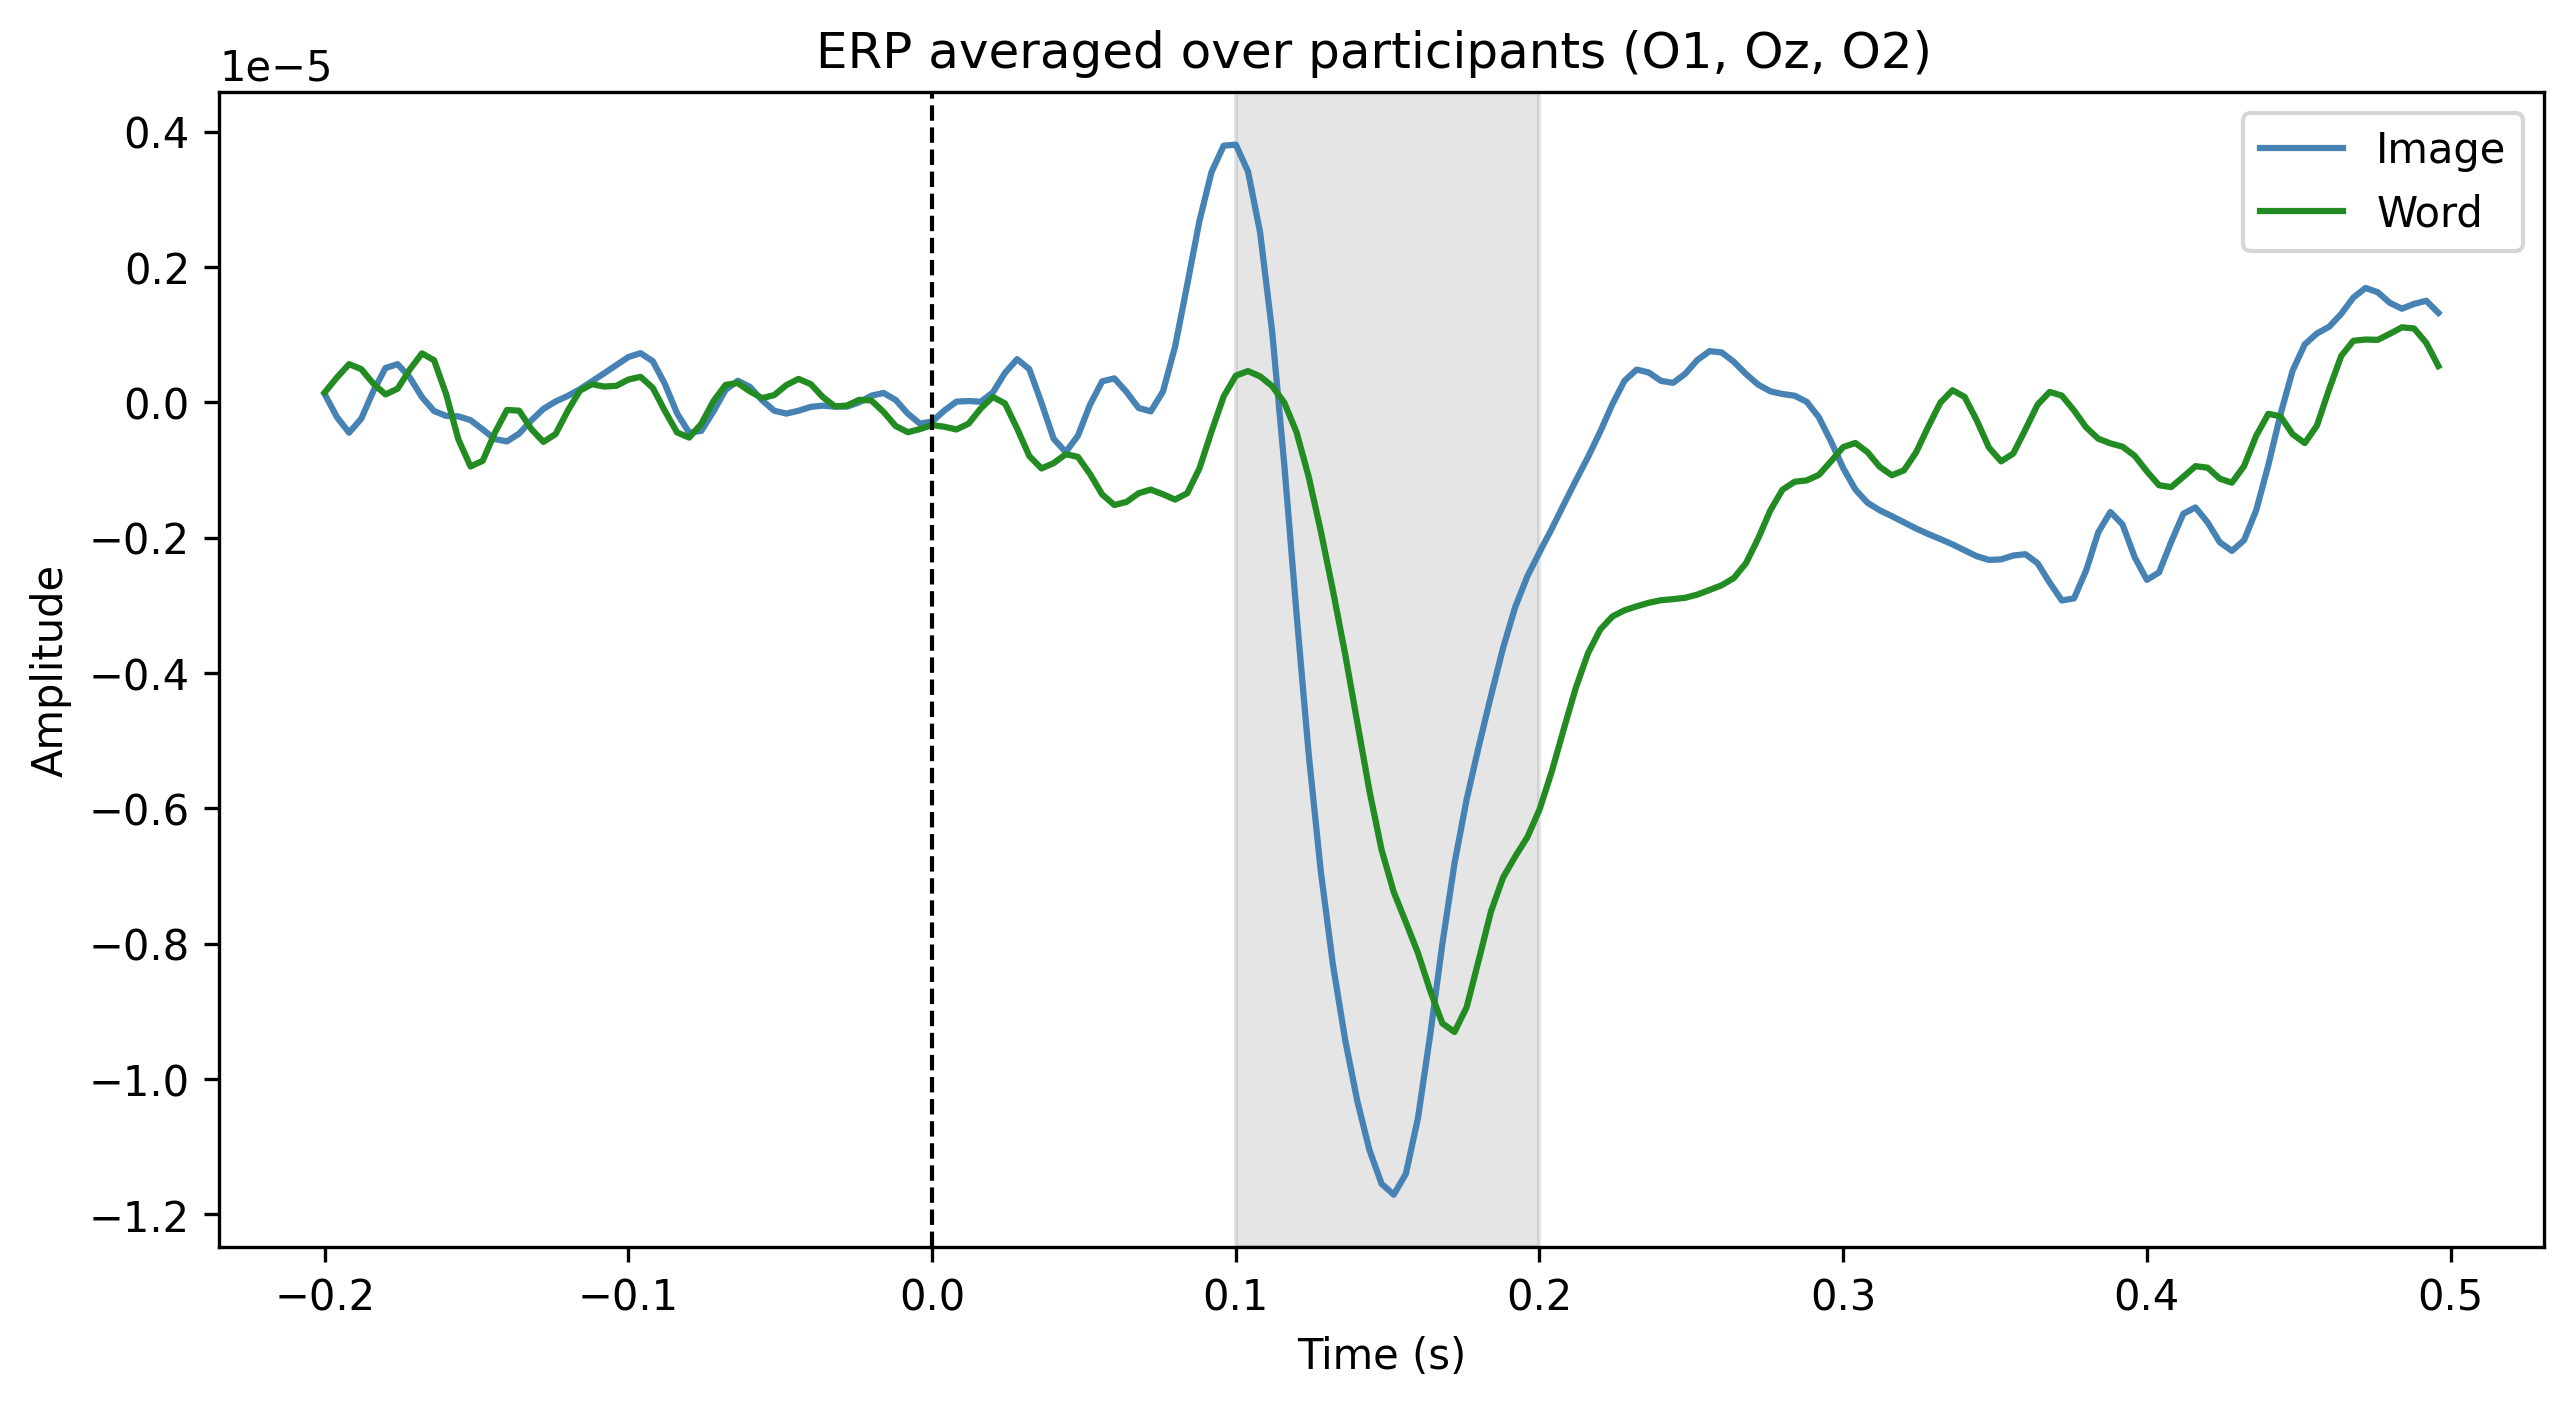

In [10]:
fig, ax = plt.subplots(1, figsize=(10, 5), dpi=300)

# plot the time window
ax.axvspan(tmin, tmax, color="grey", alpha=0.2)

ax.plot(times, avg_group_lvl_img, label="Image", linestyle="-", color=colours[0])
ax.plot(times, avg_group_lvl_word, label="Word", linestyle="-", color=colours[1])

# vertical line at 0
ax.axvline(x=0, color="black", linestyle="--", linewidth=1)

ax.set(xlabel="Time (s)", ylabel="Amplitude", title="ERP averaged over participants (O1, Oz, O2) ")
ax.legend()
plt.savefig("plots/figure1.png")

One problem with the plot above is that we do not really know how each participant contributed to the average. To get a better understanding of the data, we can plot the ERPs for each participant and condition. This will give us a better understanding of the data and will allow us to see if there are any outliers.

0
1
2


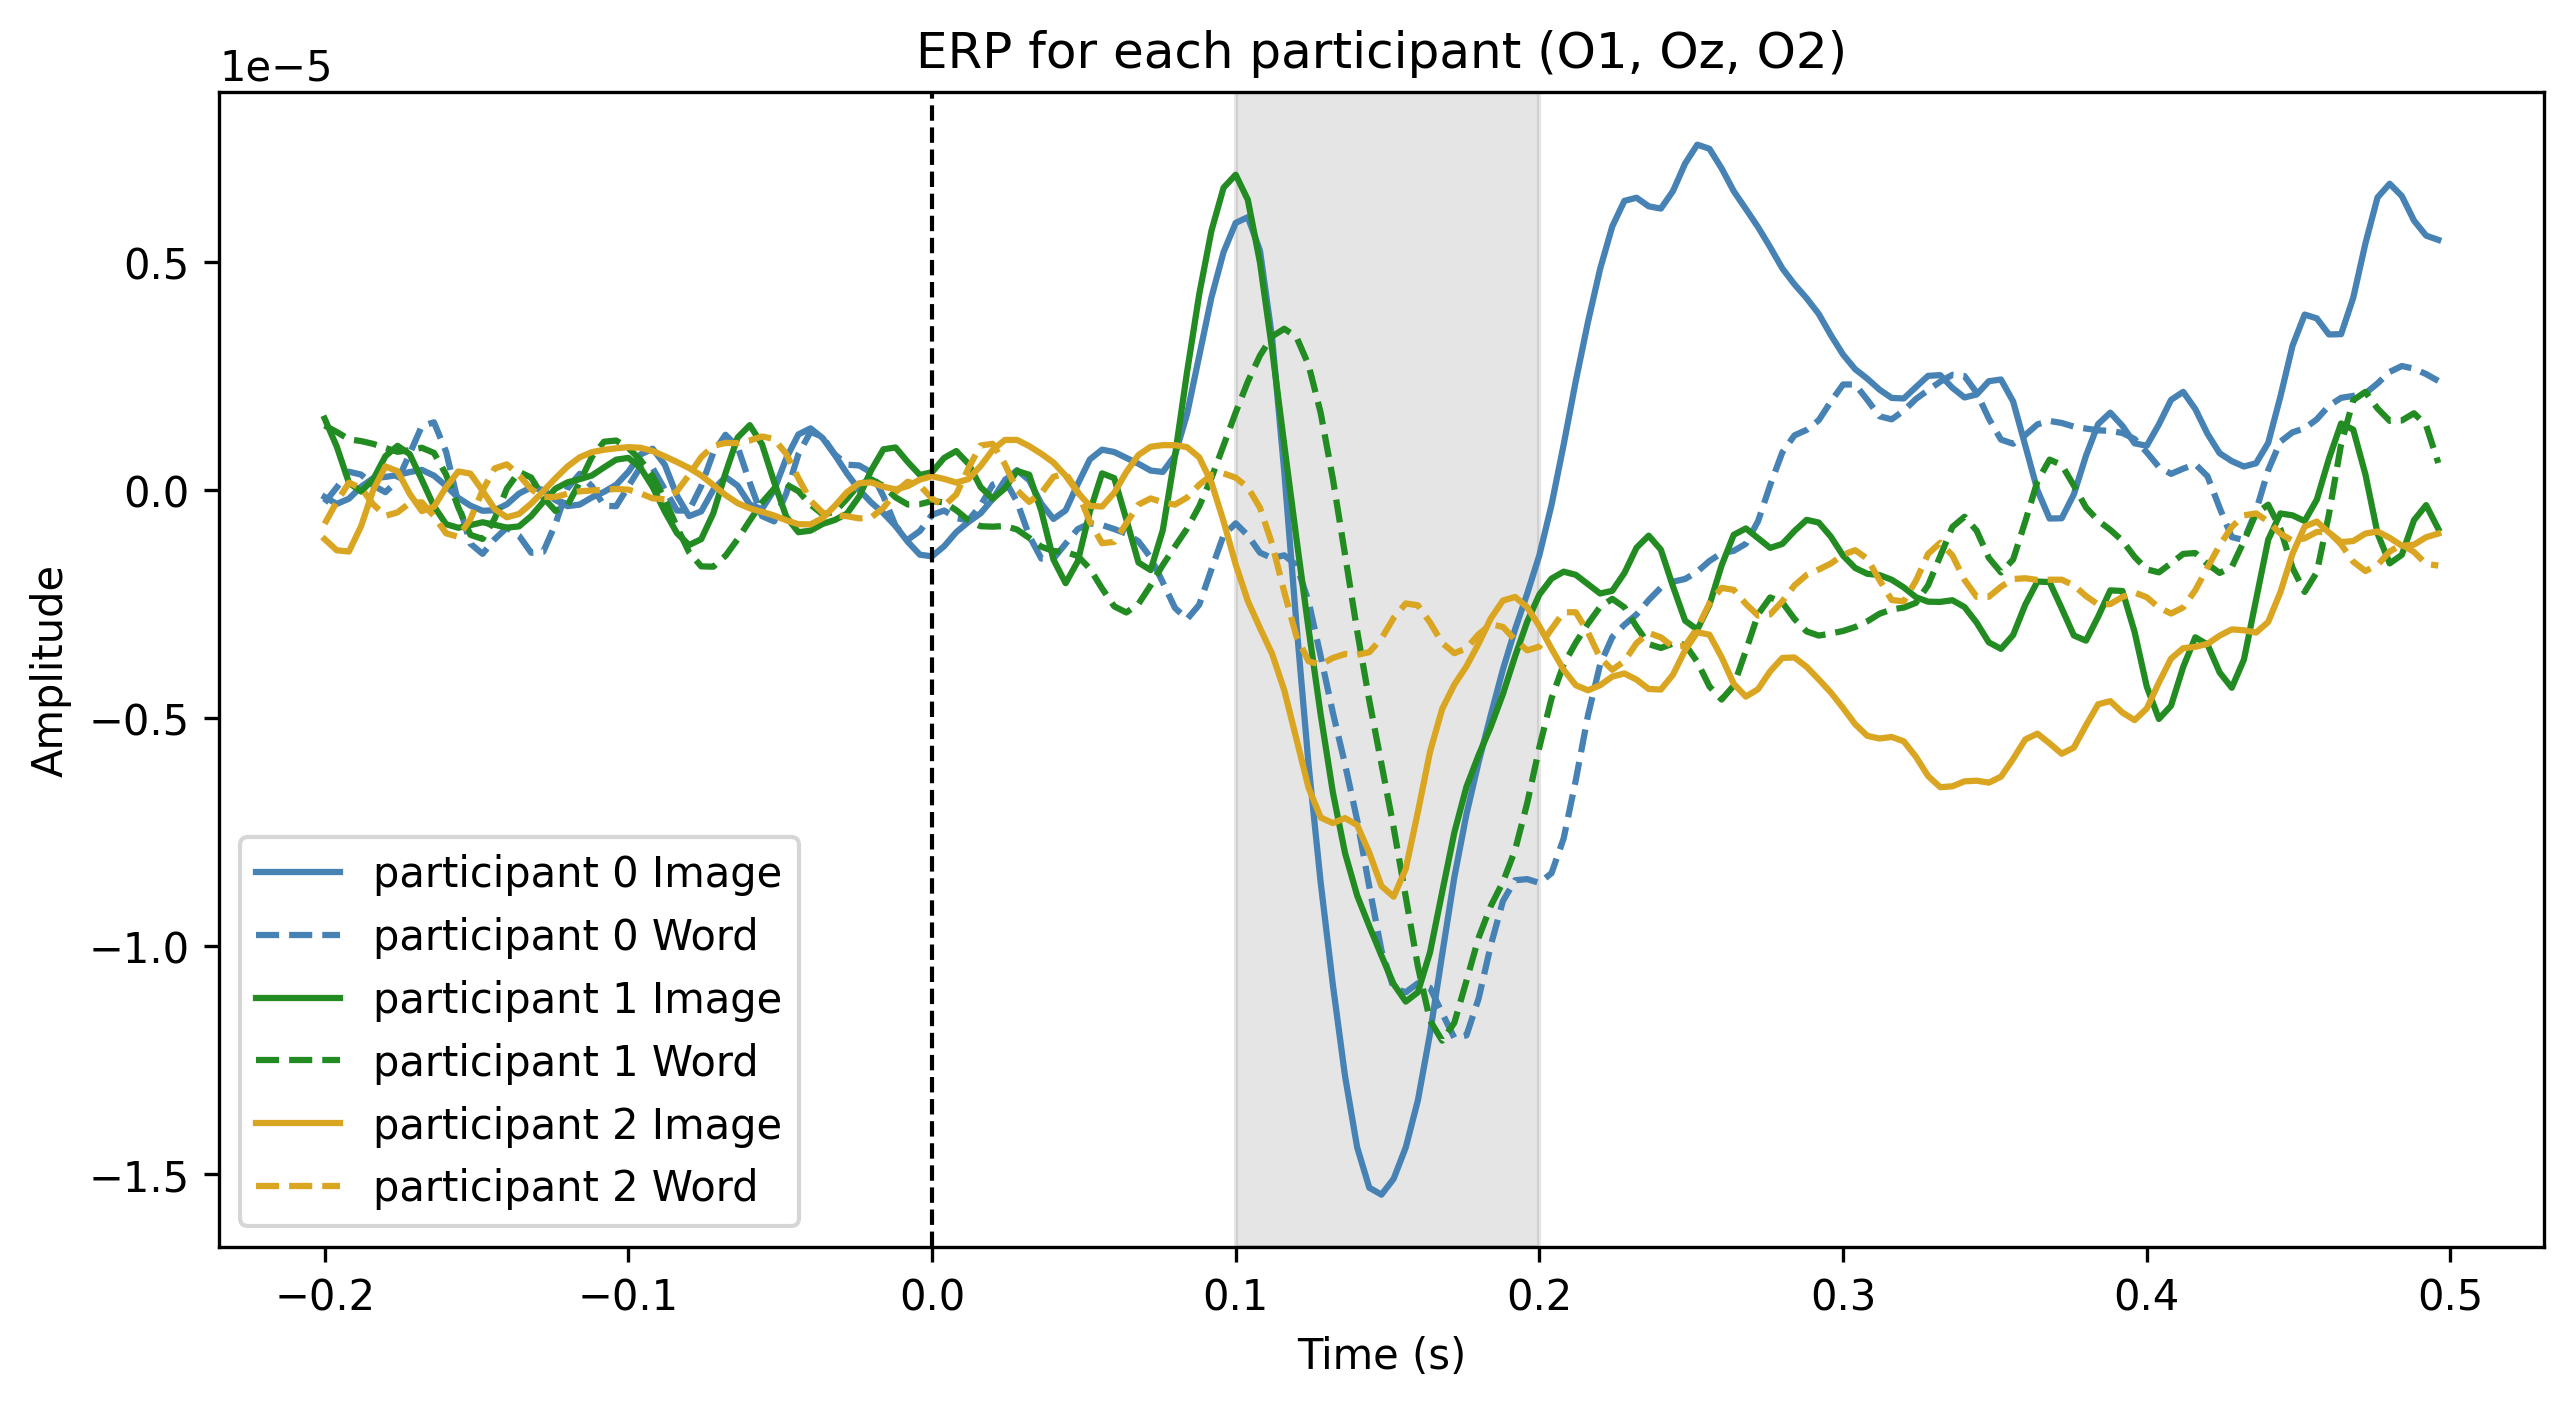

In [22]:
fig, ax = plt.subplots(1, figsize=(10, 5), dpi=300)

# plot the time window
ax.axvspan(tmin, tmax, color="grey", alpha=0.2)

for i, (img, word) in enumerate(zip(plotting_data_img.values(), plotting_data_word.values())):
    ax.plot(times, np.mean(img, axis=0), linestyle="-", color=colours[i], label = f"participant {i} Image")
    ax.plot(times, np.mean(word, axis=0), linestyle="--", color=colours[i], label = f"participant {i} Word")

# vertical line at 0
ax.axvline(x=0, color="black", linestyle="--", linewidth=1)

ax.set(xlabel="Time (s)", ylabel="Amplitude", title="ERP for each participant (O1, Oz, O2)")
ax.legend()

plt.savefig("plots/figure2.png")

From this it can be a bit hard to tell if there is a difference between the two conditions. Therefore, we add a subplot with the difference between the two conditions for each participant.

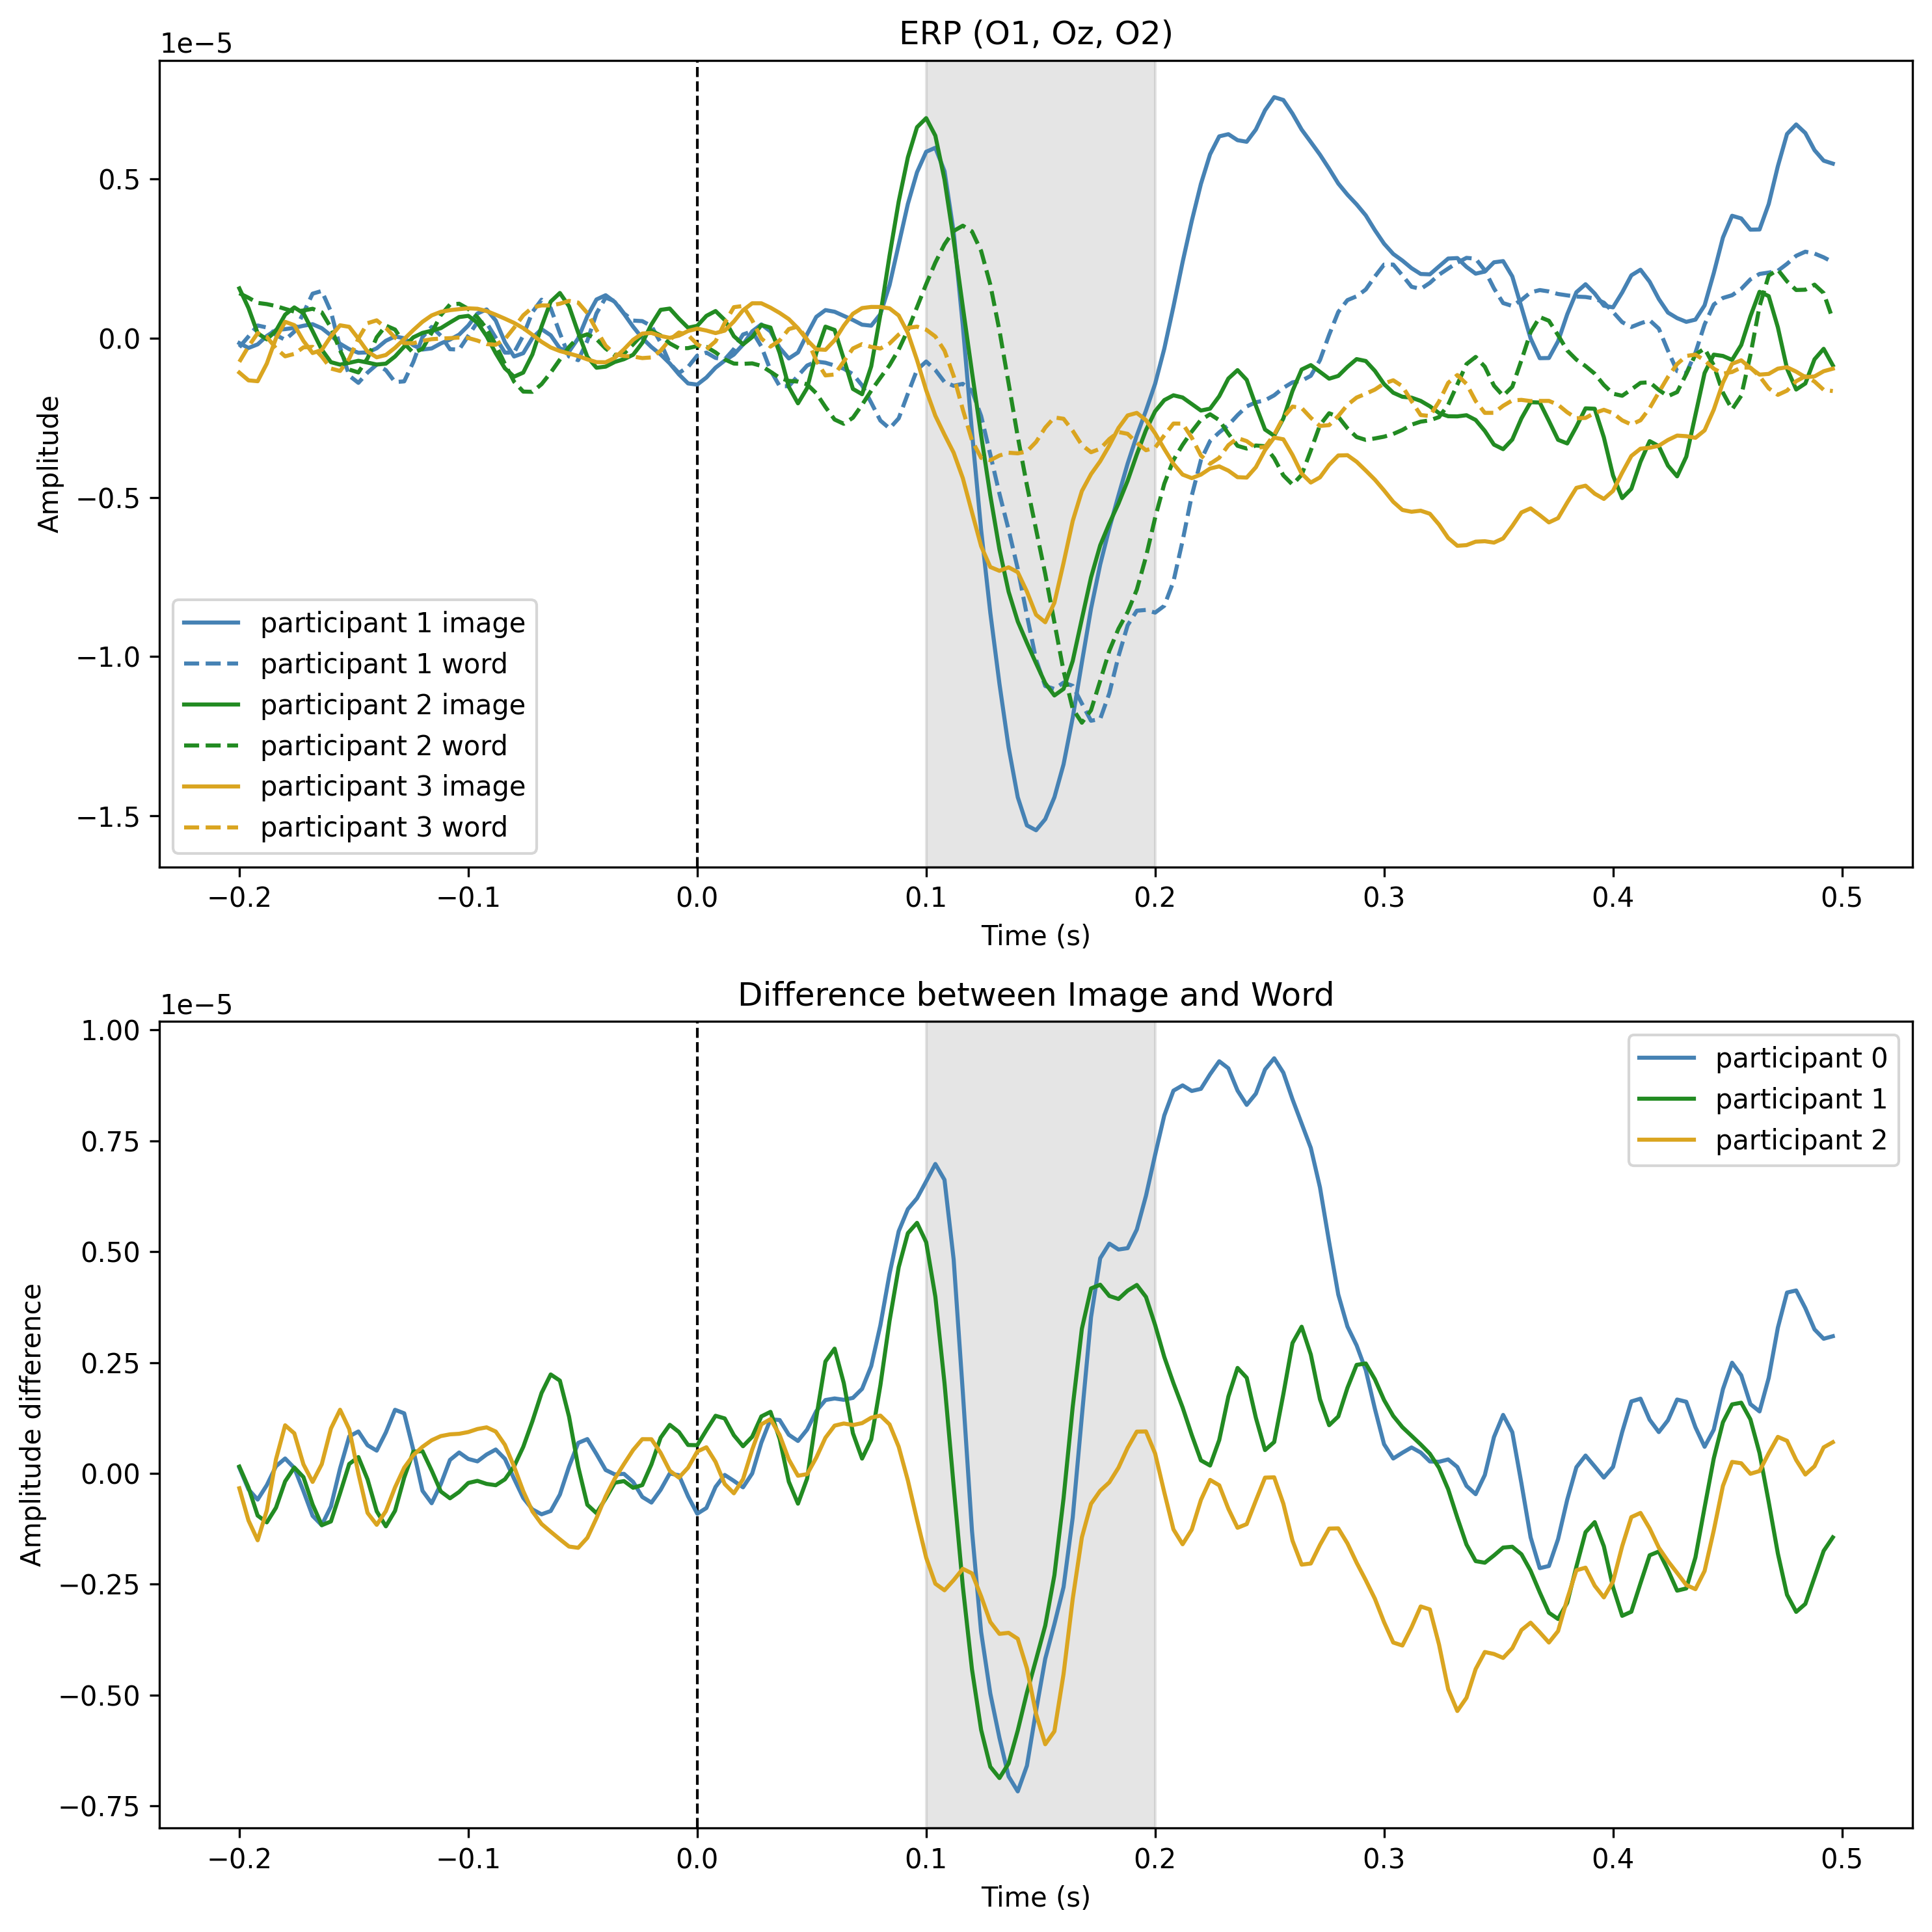

In [32]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10), dpi=300)

# plot the time window
for ax in axes.flat:
    ax.axvspan(tmin, tmax, color="grey", alpha=0.2)
    # vertical line at 0
    ax.axvline(x=0, color="black", linestyle="--", linewidth=1)


for i, (img, word) in enumerate(zip(plotting_data_img.values(), plotting_data_word.values())):
    avg_participant_img = np.mean(img, axis=0)
    avg_participant_word = np.mean(word, axis=0)

    axes[0].plot(times, avg_participant_img, linestyle="-", color=colours[i], label = f"participant {i+1} image")
    axes[0].plot(times, avg_participant_word, linestyle="--", color=colours[i], label = f"participant {i+1} word")

    # add the difference to the second plot
    axes[1].plot(times, avg_participant_img - avg_participant_word, linestyle="-", color=colours[i], label = f"participant {i}")


axes[0].set(xlabel="Time (s)", ylabel="Amplitude", title="ERP (O1, Oz, O2)")

axes[1].set(xlabel="Time (s)", ylabel="Amplitude difference", title="Difference between Image and Word")

for ax in axes.flat:
    ax.legend()

plt.tight_layout()
plt.savefig("plots/figure3.png")